In [19]:
#importing all the libraries

import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [20]:
meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
unique_lesion_ids = meta['lesion_id'].unique()

train_ids, temp_ids = train_test_split(unique_lesion_ids, test_size=0.3)
test_ids, validation_ids = train_test_split(temp_ids, test_size=0.5)

train_meta = meta[meta['lesion_id'].isin(train_ids)]
test_meta = meta[meta['lesion_id'].isin(test_ids)]
validation_meta = meta[meta['lesion_id'].isin(validation_ids)]

print(f"train ({100 * len(train_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{train_meta.head()}\n")
print(f"test ({100 * len(test_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{test_meta.head()}\n")
print(f"validation ({100 * len(validation_meta) / (len(train_meta) + len(test_meta) + len(validation_meta))}%):\n{validation_meta.head()}\n")


train (69.85521717423865%):
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

test (14.957563654518223%):
      lesion_id      image_id   dx dx_type   age     sex     localization
21  HAM_0003301  ISIC_0025033  bkl   histo  60.0    male             back
22  HAM_0003301  ISIC_0027310  bkl   histo  60.0    male             back
23  HAM_0004884  ISIC_0032128  bkl   histo  75.0    male  upper extremity
24  HAM_0004884  ISIC_0025937  bkl   histo  75.0    male  upper extremity
46  HAM_0002299  ISIC_0025819  bkl   histo  75.0  female             face

validation (15.187219171243136%):
      lesion_id      image_id   dx dx_type   age     sex     l

In [21]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, dir_part1, dir_part2, transform = None):
        self.annotation = dataframe
        self.dir_part1 = dir_part1
        self.dir_part2 = dir_part2
        self.transform = transform
        self.label_map = {
             'akiec': 0, 
             'bcc': 1, 
             'bkl': 2, 
             'df': 3, 
             'mel': 4, 
             'nv': 5, 
             'vasc': 6}

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        img_id = self.annotation.iloc[index]['image_id']#ImageID on column 2

        path_part1 = os.path.join(self.dir_part1, img_id + '.jpg')
        path_part2 = os.path.join(self.dir_part2, img_id + '.jpg')
        if os.path.exists(path_part1):
            img_name = path_part1
        elif os.path.exists(path_part2):
            img_name = path_part2
        else:
            raise FileNotFoundError(f"Image {img_id} not found in part1 or part2")
            
        image = Image.open(img_name).convert('RGB')
        
        label_text = self.annotation.iloc[index]['dx']
        y_label = torch.tensor(self.label_map[label_text])

        if self.transform:
            image = self.transform(image)

        return image, y_label



In [22]:
from torchvision import transforms

# Training transforms (Randomness added)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),       
    transforms.ToTensor(),               
    transforms.Normalize(                # Standardizes to ImageNet distribution
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (No Randomness, just resizing)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
def get_device():
    if torch.cuda.is_available():
        print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    
    elif torch.backends.mps.is_available():
        print("✅ Apple Silicon GPU Detected")
        return torch.device("mps")
    
    else:
        print("⚠️ No GPU detected. Training will be slow.")
        return torch.device("cpu")


device = get_device()

✅ GPU Detected: Tesla P100-PCIE-16GB


In [24]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        return x
        

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #feature extraction
        self.block1 = DoubleConvBlock(3, 32)
        self.block2 = DoubleConvBlock(32, 64)
        self.block3 = DoubleConvBlock(64, 128)
        self.block4 = DoubleConvBlock(128, 256)
        
        self.flatten_size = 256 * 14 * 14
        
        # First fully connected layer
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.2)
        # Second fully connected layer 
        self.fc2 = nn.Linear(512, 128)
        
        #third fully connected layer that outputs our 10 labels
        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        #flatten the data
        x = x.view(-1, self.flatten_size)
        #FC layers
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

skinCancerCNN = SkinCancerCNN()
print(skinCancerCNN)

SkinCancerCNN(
  (block1): DoubleConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): DoubleConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): DoubleConvBlock(
    (conv1): Conv2d(64, 128, kernel_s

In [25]:
labels = meta['dx'].unique()
labels, counts = np.unique(meta['dx'], return_counts=True)
weights = 1.0 / counts 
weights = weights / weights.sum() * len(counts)
weights = torch.tensor(weights, dtype=torch.float)

weights = weights.to(device)

print(labels, counts, weights)

criterion = nn.CrossEntropyLoss(weight=weights)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc'] [ 327  514 1099  115 1113 6705  142] tensor([0.9431, 0.6000, 0.2806, 2.6816, 0.2771, 0.0460, 2.1717],
       device='cuda:0')


In [26]:
learning_rate = 0.0001

optimizer = optim.Adam(skinCancerCNN.parameters(), learning_rate)


In [27]:
# Define your paths (Adjust these to match your specific Kaggle input structure)
dir_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/"
dir_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/"

# Create Datasets passing BOTH directories
train_dataset = SkinCancerDataset(train_meta, dir_1, dir_2, transform=train_transforms)
val_dataset = SkinCancerDataset(validation_meta, dir_1, dir_2, transform=val_transforms)
test_dataset = SkinCancerDataset(test_meta, dir_1, dir_2, transform=val_transforms)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

🚀 Starting training on cuda with Early Stopping...


Epoch [1/40]  Train Loss: 1.7198 | Val Loss: 1.2932 | Val Acc: 49.31%
   ✅ Validation Loss Improved. Model Saved.


Epoch [2/40]  Train Loss: 1.4846 | Val Loss: 1.1166 | Val Acc: 51.22%
   ✅ Validation Loss Improved. Model Saved.


Epoch [3/40]  Train Loss: 1.4308 | Val Loss: 1.4545 | Val Acc: 47.60%
   ⚠️ No improvement for 1/5 epochs.


Epoch [4/40]  Train Loss: 1.3420 | Val Loss: 1.2393 | Val Acc: 53.32%
   ⚠️ No improvement for 2/5 epochs.


Epoch [5/40]  Train Loss: 1.3130 | Val Loss: 1.0894 | Val Acc: 56.80%
   ✅ Validation Loss Improved. Model Saved.


Epoch [6/40]  Train Loss: 1.2885 | Val Loss: 1.1384 | Val Acc: 52.53%
   ⚠️ No improvement for 1/5 epochs.


Epoch [7/40]  Train Loss: 1.2580 | Val Loss: 1.0510 | Val Acc: 57.59%
   ✅ Validation Loss Improved. Model Saved.


Epoch [8/40]  Train Loss: 1.2450 | Val Loss: 1.1175 | Val Acc: 55.10%
   ⚠️ No improvement for 1/5 epochs.


Epoch [9/40]  Train Loss: 1.1917 | Val Loss: 1.0718 | Val Acc: 55.62%
   ⚠️ No improvement for 2/5 epochs.


Epoch [10/40]  Train Loss: 1.1889 | Val Loss: 1.0841 | Val Acc: 55.75%
   ⚠️ No improvement for 3/5 epochs.


Epoch [11/40]  Train Loss: 1.1645 | Val Loss: 1.0399 | Val Acc: 56.80%
   ✅ Validation Loss Improved. Model Saved.


Epoch [12/40]  Train Loss: 1.1359 | Val Loss: 1.0572 | Val Acc: 55.88%
   ⚠️ No improvement for 1/5 epochs.


Epoch [13/40]  Train Loss: 1.1244 | Val Loss: 1.0583 | Val Acc: 57.46%
   ⚠️ No improvement for 2/5 epochs.


Epoch [14/40]  Train Loss: 1.0935 | Val Loss: 1.0189 | Val Acc: 58.91%
   ✅ Validation Loss Improved. Model Saved.


Epoch [15/40]  Train Loss: 1.1127 | Val Loss: 1.0878 | Val Acc: 54.24%
   ⚠️ No improvement for 1/5 epochs.


Epoch [16/40]  Train Loss: 1.1022 | Val Loss: 1.0163 | Val Acc: 58.84%
   ✅ Validation Loss Improved. Model Saved.


Epoch [17/40]  Train Loss: 1.0447 | Val Loss: 0.9853 | Val Acc: 59.17%
   ✅ Validation Loss Improved. Model Saved.


Epoch [18/40]  Train Loss: 1.0645 | Val Loss: 0.9202 | Val Acc: 62.98%
   ✅ Validation Loss Improved. Model Saved.


Epoch [19/40]  Train Loss: 1.0388 | Val Loss: 1.0658 | Val Acc: 59.04%
   ⚠️ No improvement for 1/5 epochs.


Epoch [20/40]  Train Loss: 0.9949 | Val Loss: 0.9245 | Val Acc: 62.98%
   ⚠️ No improvement for 2/5 epochs.


Epoch [21/40]  Train Loss: 1.0031 | Val Loss: 1.5672 | Val Acc: 41.22%
   ⚠️ No improvement for 3/5 epochs.


Epoch [22/40]  Train Loss: 0.9514 | Val Loss: 0.9893 | Val Acc: 59.83%
   ⚠️ No improvement for 4/5 epochs.


Epoch [23/40]  Train Loss: 0.9481 | Val Loss: 0.9754 | Val Acc: 60.09%
   ⚠️ No improvement for 5/5 epochs.

🛑 Early Stopping Triggered! Training stopped at Epoch 23.
Training Finished.


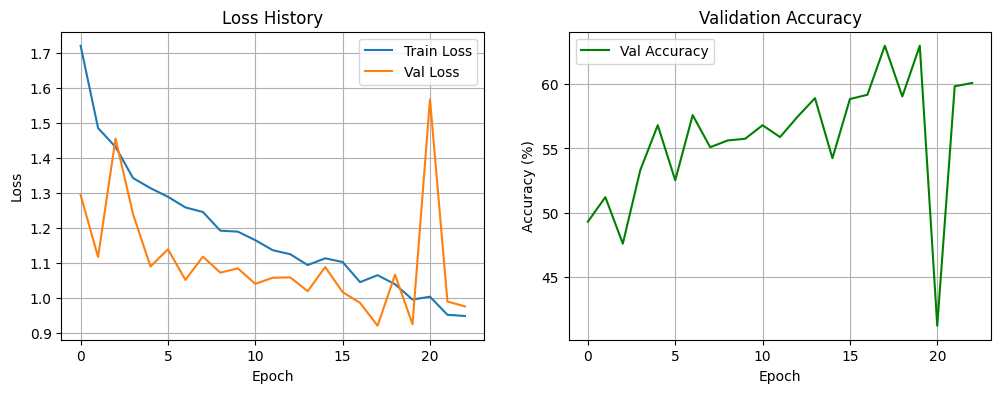

In [28]:
import time
from tqdm import tqdm # Library for progress bars
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
patience = 5        # How many epochs to wait before stopping if no improvement
min_delta = 0.001   # Minimum change to qualify as an improvement
early_stop_counter = 0
best_val_loss = float('inf')
num_epochs = 40

# Move model to device
model = skinCancerCNN.to(device)

# History storage
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"🚀 Starting training on {device} with Early Stopping...")

# ==========================================
# TRAINING LOOP
# ==========================================
for epoch in range(num_epochs):
    
    # --- 1. Training Phase ---
    model.train()
    running_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    # 'desc' sets the text before the bar
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Update progress bar with current loss
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_loss)

    # --- 2. Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_acc = 100 * correct / total
    
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_acc)

    # Print Clean Stats
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}%")

    # ==========================================
    # EARLY STOPPING LOGIC
    # ==========================================
    # Check if this validation loss is the best we've seen
    if epoch_val_loss < (best_val_loss - min_delta):
        best_val_loss = epoch_val_loss
        early_stop_counter = 0 # Reset counter
        torch.save(model.state_dict(), 'best_skin_cancer_model.pth')
        print(f"   ✅ Validation Loss Improved. Model Saved.")
    else:
        early_stop_counter += 1
        print(f"   ⚠️ No improvement for {early_stop_counter}/{patience} epochs.")
        
    if early_stop_counter >= patience:
        print(f"\n🛑 Early Stopping Triggered! Training stopped at Epoch {epoch+1}.")
        break

print("Training Finished.")

# ==========================================
# VISUALIZATION
# ==========================================
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['val_acc'], label='Val Accuracy', color='green')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Run the plot
plot_training_history(history)